In [1]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import os

In [2]:
class Config:
    base_pth = Path('/kaggle/input/konwinski-prize')
    datazip_pth = Path('/kaggle/input/konwinski-prize/data')
    working_pth = Path('/kaggle/working')
    repo_pth = Path('/kaggle/working')
    data_pth = Path('/kaggle/working/data')
    repo_pth = Path('/kaggle/working/data/repos')

In [3]:
!unzip -q /kaggle/input/konwinski-prize/data.a_zip

In [4]:
df = pd.read_parquet(Config.working_pth / "data/data.parquet")
df

,instance_id,repo,problem_statement,patch,test_patch,pull_number,base_commit,PASS_TO_PASS,FAIL_TO_PASS,issue_numbers
0,pylint-dev__astroid-2496,pylint-dev/astroid,TypeError: unsupported format string passed to...,diff --git a/ChangeLog b/ChangeLog\nindex 4560...,diff --git a/tests/test_inference.py b/tests/t...,2496,8d3cdbbe6685fd8cf211816bec56c90f38f1859e,[tests/test_inference.py::InferenceUtilsTest::...,[tests/test_inference.py::test_formatted_fstri...,[2492]
1,pylint-dev__astroid-2468,pylint-dev/astroid,Pylint checks against incorrect type with prop...,diff --git a/ChangeLog b/ChangeLog\nindex fdbb...,diff --git a/tests/test_inference.py b/tests/t...,2468,6db3a60553ff538a936d5dda23d67a3924a57f45,[tests/test_inference.py::InferenceUtilsTest::...,[tests/test_inference.py::InferenceTest::test_...,[2467]
2,astropy__astropy-17048,astropy/astropy,QTable cannot take `dimensionless_unscaled` wh...,diff --git a/astropy/table/table.py b/astropy/...,diff --git a/astropy/table/tests/test_table.py...,17048,d60f6b72cd525262bfd179331d9fe4474177918f,[astropy/table/tests/test_table.py::TestSetTab...,[astropy/table/tests/test_table.py::test_qtabl...,[17047]
3,astropy__astropy-16898,astropy/astropy,BUG: tables do not deal well with zero-sized s...,diff --git a/astropy/io/registry/core.py b/ast...,diff --git a/astropy/io/fits/tests/test_connec...,16898,ee6d087baf301c1d08db92e6e5b6d909d57e6fac,[astropy/io/fits/tests/test_connect.py::TestSi...,[astropy/io/fits/tests/test_connect.py::test_z...,[16897]
4,astropy__astropy-16830,astropy/astropy,KeyError: 'version_1_3_or_later' when parsing ...,diff --git a/astropy/io/votable/tree.py b/astr...,diff --git a/astropy/io/votable/tests/test_tre...,16830,e39f486fec48d87aa3677326167954370d7a7bf9,[astropy/io/votable/tests/test_tree.py::test_c...,[astropy/io/votable/tests/test_tree.py::test_v...,"[16825, 16826]"
5,astropy__astropy-16812,astropy/astropy,Provide a way to make a copy of a model with d...,diff --git a/astropy/modeling/core.py b/astrop...,diff --git a/astropy/modeling/tests/test_core....,16812,c241103c11954d3c1cfe3c1840b1ece72479c522,[astropy/modeling/tests/test_core.py::test_Mod...,[astropy/modeling/tests/test_core.py::test_res...,[16593]


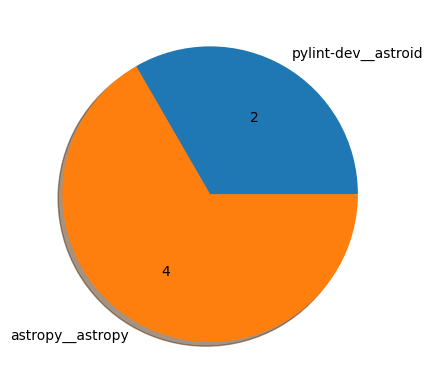

In [5]:
cntr = {}

for i in df['instance_id']:
    x = re.search("(.*)-\d+", i)
    if x:
        repo_name = x.group(1)
        if repo_name not in cntr:
            cntr[repo_name] = 1
        else:
            cntr[repo_name] += 1

vals = list(cntr.values())
keys = list(cntr.keys())
p, tx, autotexts = plt.pie([float(v) for v in vals], labels=[str(k) for k in keys], autopct='%1.1f%%', shadow=True)

for i, a in enumerate(autotexts):
    a.set_text("{}".format(vals[i]))

The above pie chart shows the distinct repos that are present in the input data along with the count of states for the repo.

What is the meaning of state?<br/>
Git is a version control software. A repository managed by Git will have iterations of edits stacked on top of each other. Each iteration is called a commit in Git world. State refers to the state of all the files at the time when the patch was applied on them. Applying the patch mutates the state of the repo.

# Repository sizes

A git repository in the most normie sense is directory containing a bunch of files. Ideally one would want the LLM to know each and every line of code in every file of the repo. This is a challenge as repositories can have "any" number of files. The goal of this section is to put a number on "any".

In [6]:
file_cnt = {"Repo state": [], "File count": [], "Line count": []}

for repo_state in os.listdir(Config.repo_pth):
    fc = 0
    lc = 0
    for r, d, files in os.walk(Config.repo_pth / repo_state): 
        fc += len(files)
        for file in files:
            try:
                lc += sum(1 for _ in open(f'{r}/{file}'))
            except:
                pass
    file_cnt["Repo state"].append(repo_state)
    file_cnt["File count"].append(fc)
    file_cnt["Line count"].append(lc)

file_cnt_df = pd.DataFrame(file_cnt)
file_cnt_df

,Repo state,File count,Line count
0,repo__pylint-dev__astroid-2468,314,68094
1,repo__astropy__astropy-16830,1852,724683
2,repo__pylint-dev__astroid-2496,313,68244
3,repo__astropy__astropy-16812,1847,724601
4,repo__astropy__astropy-16898,1861,724959
5,repo__astropy__astropy-17048,1879,728356


Gemini pro 1.5 is the current leader in the number of context tokens that it can take in standing at 1M. ([ref](https://token-calculator.net/))

1M context token roughly translates to 50,000 lines of code ([ref](https://ai.google.dev/gemini-api/docs/long-context)) which is less than the least that we are seeing in the sample input.